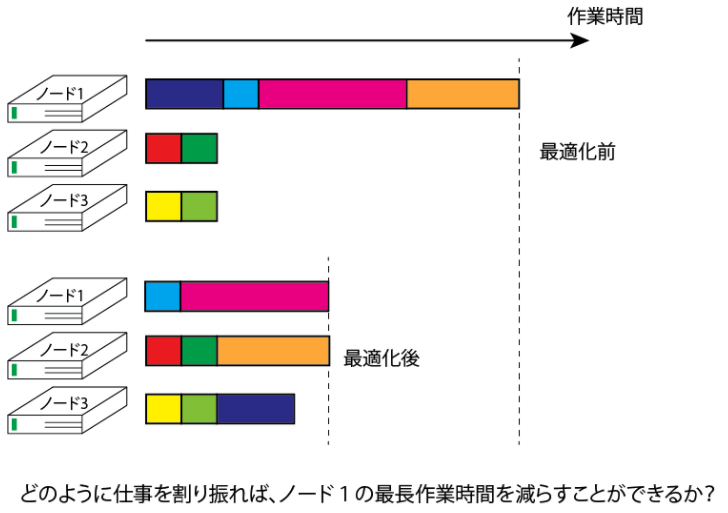

αノード番目のジョブの集合をVαとすると、αノード番目の作業時間の合計は

$$
\displaystyle{
M_\alpha 
= \sum_{i\in V_\alpha} L_i
}
$$
となります。そして問題は

$$
\displaystyle{
\min \{\max (M_\alpha) \}
}
$$
となる組合せを探すことになります。ここでジョブの総実行時間が最大となるノードを1としても一般性を失わないため、以降ではノード1の総実行時間を最小化することを考えましょう。ちなみに、この問題はNP困難であることが知られています。

# バイナリ変数
最適化に使用するバイナリ変数を、ノードαでジョブiを行うときxi,α=1、それ以外ならば0と定義します。

またyn,αをノード1とノードαの仕事量の差nを表す変数とします。具体的には$M_1 - M_\alpha = n \ (\alpha \neq 1, n \geq 0)$ のとき $y_{n, \alpha} = 1$、それ以外のとき0と定義します。

# それぞれのジョブに対するone-hot encoding

あるジョブiはいずれか一つのノードで実行されなければなりません。よって

$$
\displaystyle{
\sum_{\alpha} x_{i, \alpha}= 1 
}
$$

となります。

# あるノードでの総実行時間に対するone-hot encoding

yn,αの定義から、ノードαでの総実行時間$\sum_i L_i x_{i, \alpha}$とノード1の総実行時間$\sum_i L_i x_{i, \alpha}$との差の間に、以下のような関係が成り立たなければなりません。

$$
\displaystyle{
\sum_{n=0}^{\mathcal{M}} n y_{n, \alpha} = \sum_i L_i (x_{i, 1} - x_{i, \alpha})
}
$$

ここで$\mathcal{M}$はユーザが指定する変数で、許容されるノード1とノードαの総実行時間の差を表します。またyn,αに対するone-hot encodingも必要になります。
またyn,αに対するone-hot encodingも必要になります。

$$
\displaystyle{
\sum_{n=0}^\mathcal{M} y_{n, \alpha} = 1
}
$$

In [1]:
import numpy as np
#コンピュータの数
m=3
#仕事の長さ
L= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#仕事の数
N=len(L)

In [2]:
M = 3

In [3]:
#PYQUBOをimportします
from pyqubo import Array,LogEncInteger

x = Array.create('x', shape=(N,m), vartype='BINARY')
y =  LogEncInteger('y',(0,M))

In [4]:
from pyqubo import Constraint
A2=36

A1=(A2/max(L) **2)/0.12

B = (A2/max(L))/3.6

# ハミルトニアンの第一項
const = 0
for a in range(1,m):
    const += (M - sum([L[i]*(x[i,0]-x[i,a]) for i in range(N)])-y)**2
HA1 = Constraint(const, label='HA1')

# ハミルトニアンの第二項
HA2 = Constraint(sum((1-sum(x[i,a] for a in range(m)))**2 for i in range(N)), label='HA2')

# ハミルトニアンの第三項
HB = sum(L[i] * x[i,0] for i in range(N))

# ハミルトニアン全体を定義します
Q = A1*HA1+A2*HA2+B*HB

In [5]:
from pyqubo import solve_qubo

model = Q.compile()
qubo, offset = model.to_qubo()

# nealを用いて使います
import neal
sampler = neal.SimulatedAnnealingSampler()
raw_solution = sampler.sample_qubo(qubo, num_reads=500)
decoded_sample = model.decode_sample(raw_solution.first.sample, vartype="BINARY")
#結果の表示
print("[Inputs]")
print()
print("N (仕事の数) : "+str(N)+"個")
print("m (コンピュータの数): "+str(m))
print()
print("仕事の長さのリスト")
print(L)
print()
print("A1 : "+str(A1))
print("A2 : "+str(A2))
print("B : "+str(B))
print()
print("[Results]")
print()
job_length = [0] * m
for i in range(0,m):
    print("コンピュータ"+str(i+1)+"で行われる仕事")
    for j in range(0,N):
        if decoded_sample.array('x', (j,i))==1:
            print(str(j+1)+"番目の仕事 長さ:"+str(L[j]))
            job_length[i] += L[j]
    print("仕事の総実行時間:"+str(job_length[i]))
    print()

print("broken")
print(decoded_sample.constraints(only_broken=True))


[Inputs]

N (仕事の数) : 10個
m (コンピュータの数): 3

仕事の長さのリスト
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

A1 : 3.0
A2 : 36
B : 1.0

[Results]

コンピュータ1で行われる仕事
9番目の仕事 長さ:9
10番目の仕事 長さ:10
仕事の総実行時間:19

コンピュータ2で行われる仕事
1番目の仕事 長さ:1
2番目の仕事 長さ:2
3番目の仕事 長さ:3
5番目の仕事 長さ:5
7番目の仕事 長さ:7
仕事の総実行時間:18

コンピュータ3で行われる仕事
4番目の仕事 長さ:4
6番目の仕事 長さ:6
8番目の仕事 長さ:8
仕事の総実行時間:18

broken
{}


In [6]:
# OpenJijのインポートをします
import openjij as oj
# SQAを使います。
sampler = oj.SQASampler()
# PYQUBOで使ったquboを使います。
response = sampler.sample_qubo(Q=qubo, num_reads=300)
# エネルギーが一番低い状態を取り出します。
dict_solution = response.first.sample
# デコードします。
decoded_sample = model.decode_sample(raw_solution.first.sample, vartype="BINARY")
#結果の表示
print("[Results]")
print()
job_length = [0] * m
for i in range(0,m):
    print("コンピュータ"+str(i+1)+"で行われる仕事")
    for j in range(0,N):
        if decoded_sample.array('x', (j,i))==1:
            print(str(j+1)+"番目の仕事 長さ:"+str(L[j]))
            job_length[i] += L[j]
    print("仕事の総実行時間:"+str(job_length[i]))
    print()

print("broken")
print(decoded_sample.constraints(only_broken=True))

[Results]

コンピュータ1で行われる仕事
9番目の仕事 長さ:9
10番目の仕事 長さ:10
仕事の総実行時間:19

コンピュータ2で行われる仕事
1番目の仕事 長さ:1
2番目の仕事 長さ:2
3番目の仕事 長さ:3
5番目の仕事 長さ:5
7番目の仕事 長さ:7
仕事の総実行時間:18

コンピュータ3で行われる仕事
4番目の仕事 長さ:4
6番目の仕事 長さ:6
8番目の仕事 長さ:8
仕事の総実行時間:18

broken
{}
